# Gmail analysis
### Exploring more than 13 years of Gmail messages

I learned recently that Google allows its users to download metadata for all the messages sent and received through Gmail. This leads to interesting insights to be found in the data: *What are the most common people I have been in touch with? What days of the week or time of the day have the highest trafic?* In order to explore these and other questions I decided to request my data and perform the present analysis.

The first step is [requesting the data](https://takeout.google.com/settings/takeout). There is data available for several Google services, only the Gmail data is used here. Depending on the amount of data the request can take several hours (my file is 8.2GB). Once we are notified that the file is ready to be downloaded, the data will come in a special format called `mailbox`. After importing some useful modules we can clean and explore the data.

In [1]:
import mailbox
import pandas as pd
import csv
import unicodedata
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={'figure.facecolor':'white'})

from time import time
from collections import Counter

## Data preprocessing
One of the most important steps before analyzing the data is its proper cleaning, which refers to removing unnecessary data, dealing with missing values, grouping fields that appear different for the machine but that refer to the same items, etc.
We begin by saving the data file `gmail_data.mbox` in a directory called `data` (for privacy reasons, this file is absent from the GitHub repository). The file can be loaded using the `mailbox` module

In [3]:
file_path = 'data/gmail_data.mbox'
mbox = mailbox.mbox(file_path)
print('samples:', len(mbox))

samples: 69988


The file contains 69,988 samples. Even though these are mostly email messages, many other entry types are counted, such as drafts and chats. These can be removed by filtering by Gmail label. The file contains the following fields

In [3]:
# print fields
for i, key in enumerate(mbox[0].keys()):
    print(i+1, key)

1 X-GM-THRID
2 X-Gmail-Labels
3 MIME-Version
4 Received
5 Date
6 Delivered-To
7 Message-ID
8 Subject
9 From
10 To
11 Content-Type


We find that there are several section of little interest. In order to avoid loading unnecessary information, we can extract the fields of interest and put them into a `pandas` dataframe for further processing. We are interested in the following fields: `subject`, `from`, `to`, `date`, and `Gmail-label`.

In [8]:
t0 = time()
subject = []
from_ = []
to = []
date = []
label = []
for i, message in enumerate(mbox):
    try:
        if i%2000 == 0:
            print(i, end=' ')
        subject.append(message['subject'])
        from_.append(message['from'])
        to.append(message['to'])
        date.append(message['date'])
        label.append(message['X-Gmail-Labels'])
    except:
        print(i, end=' ')
        print('subject', subject[i])
        print('from', from_[i])
        print('to', to[i])
        print('date', date[i])
        print('label', label[i])
print('\ntime: {:.1f} min'.format((time()-t0)/60))

In [11]:
df = pd.DataFrame()
df['subject'] = subject
df['from'] = from_
df['to'] = to
df['date'] = date
df['label'] = label

In [19]:
df[['subject', 'date', 'label']].head()

,subject,date,label
0,consulta DS,"Tue, 8 Aug 2017 11:20:05 +0200","Important,Sent"
1,Re: consulta DS,"Tue, 08 Aug 2017 10:35:39 +0100","Important,Inbox"
2,Re: consulta DS,"Tue, 08 Aug 2017 10:43:30 +0100","Important,Inbox"
3,Re: consulta DS,"Tue, 8 Aug 2017 13:16:37 +0200",Sent
4,NaN,"Sun, 19 Nov 2017 14:28:18 +0100","Important,Inbox"


My Gmail data contains mostly messages in English; however, there is plenty of Spanish and German, which introduce special characters that can lead to encoding issues. For this reason, it is better to encode special characters such as `ñ` and letters with accents and umlauts

In [ ]:
def remove_accents(text):
    text = str(text)
    nfkd_norm = unicodedata.normalize('NFKD', text)
    text = nfkd_norm.encode('ASCII', 'ignore').decode('utf-8')
    return text

In [ ]:
df['subject'] = df['subject'].map(remove_accents)

After cleaning the `subject` field, we can get a general overview of the integrity of different fields

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69988 entries, 0 to 69987
Data columns (total 5 columns):
subject    66828 non-null object
from       69988 non-null object
to         55762 non-null object
date       56735 non-null object
label      69604 non-null object
dtypes: object(5)
memory usage: 2.7+ MB


We find that `date`, one of the most relevant fields, contains many null entries (mostly from chat entries)

In [29]:
df[df['date'].isnull()][['subject', 'to', 'date']].head()

,subject,to,date,label
16,None,NaN,NaN,Chat
26,None,NaN,NaN,Chat
90,None,NaN,NaN,Chat
91,None,NaN,NaN,Chat
92,None,NaN,NaN,Chat


The total number of null entries is

In [31]:
len(df[df['date'].isnull()])

56735

All these entries can be removed

In [32]:
# delete null rows
df = df[df['date'].notnull()]

In [33]:
len(df)

56735

We can now focus on the `date` field. The next goal is to transform the class type: dates are given as strings

In [34]:
df[['date']].head()

,date
0,"Tue, 8 Aug 2017 11:20:05 +0200"
1,"Tue, 08 Aug 2017 10:35:39 +0100"
2,"Tue, 08 Aug 2017 10:43:30 +0100"
3,"Tue, 8 Aug 2017 13:16:37 +0200"
4,"Sun, 19 Nov 2017 14:28:18 +0100"


These string dates can be converted into timestamps using the converted available for dataframes

In [7]:
df['date'] = df['date'].apply(lambda x: pd.to_datetime(x, errors='coerce', utc=True))

Some dates have unappropriate shape for conversion (these are drafts of spam messages), which can be simply removed

In [23]:
df = df[df['date'].notnull()]

Given that the date is now a timestamp, messages can be easily sorted by date, after which the dataframe index must be reset

In [27]:
df = df.sort_values(['date'], ascending=False)
df = df.reset_index(drop=True)

The most recent messages are the following

In [9]:
df[['subject', 'date', 'label']].head(8)

,subject,date,label
0,Your Google data archive is ready,2018-01-27 18:30:32+00:00,"Important,Inbox"
1,None,2018-01-27 17:48:17+00:00,"Important,Jan"
2,NaN,2018-01-27 17:17:36+00:00,Drafts
3,NaN,2018-01-27 10:21:42+00:00,"Unread,old_stuff/_KIT,Spam"
4,easy loan to obtain,2018-01-26 20:36:15+00:00,"Unread,Spam"
5,=?utf-8?Q?The=20Support=20Your=20Student=20Bod...,2018-01-26 20:24:02+00:00,"Unread,Spam"
6,None,2018-01-26 18:59:24+00:00,"Important,Jan"
7,"aantonop: ""Bitcoin Q&A: Layered scaling and pr...",2018-01-26 17:47:20+00:00,Trash


where the most recent message is the notification from Gmail to download the data used here. The oldest messages are

In [11]:
df[['subject', 'date', 'label']].tail(9)

,subject,date,label
51986,Re: Asamblea,2004-10-05 14:21:47+00:00,Inbox
51987,Asamblea,2004-10-05 12:55:58+00:00,Inbox
51988,None,2004-10-01 22:06:10+00:00,Inbox
51989,NaN,2004-09-29 18:24:55+00:00,Sent
51990,Web del teste para el cambio (fwd),2004-09-27 19:43:40+00:00,Inbox
51991,=?ISO-8859-1?B?SW5mb3JtYWNp824=?=\n\tSegunda E...,2004-09-27 16:42:58+00:00,Inbox
51992,de dayton,2004-09-14 23:29:03+00:00,Inbox
51993,Escuela del CERN,2004-09-14 14:58:38+00:00,Inbox
51994,NaN,2004-09-10 17:03:41+00:00,Inbox


Finally, there are many messages in the `Drafts` folder that should also be removed

In [317]:
df = df[df['label'] != 'Drafts']

The same applies for `Spam` messages. Unfortunately, this label does not appear alone so it must be searched in the `label` column

In [406]:
cnt = 0
idx_to_remove = []
for i, lab in enumerate(df['label']):
    if 'Spam' in str(lab):
        idx_to_remove.append(i)
        
df = df.drop(df.index[idx_to_remove])
df = df.reset_index(drop=True)

At this point, and given the time used for cleaning the data file, it is a good idea to export it as a `csv` file for future use without the need of redoing the preprocessing above.

In [407]:
df.to_csv('data/gmail_data_preprocessed.csv', 
          encoding='utf-8', index=False)

## Data exploration

We can now begin exploring the data set.

In [2]:
df = pd.read_csv('data/gmail_data_preprocessed.csv')
len(df)

51423

Since the data was loaded from a `csv` file, the dates are back as `str` so they must be converted into `timestamp` again

In [3]:
df['date'] = df['date'].apply(lambda x: pd.to_datetime(x))

### 1. Incoming vs. outgoing messages
For simplicity, all messages written by me or sent to me can be labeled by the string `me` instead of my email address. This will make the identification of incoming and outgoing emails easier. For this the following helper function returns `me` my email address is found and leaves the text unchanged, otherwise:

In [4]:
def rename_me(txt):
    txt = str(txt).lower()
    if('jsdiaz' in txt or
       'jorge.diaz' in txt):
        txt_out = 'me'
    else:
        txt_out = txt
    return txt_out

In [6]:
df['from'] = df['from'].apply(rename_me)
df['to'] = df['to'].apply(rename_me)

In [7]:
df[['subject', 'to', 'date', 'label']].head(4)

,subject,to,date,label
0,Your Google data archive is ready,me,2018-01-27 18:30:32,"Important,Inbox"
1,None,me,2018-01-27 17:48:17,"Important,Jan"
2,None,me,2018-01-26 18:59:24,"Important,Jan"
3,"aantonop: ""Bitcoin Q&A: Layered scaling and pr...",me,2018-01-26 17:47:20,Trash


Since we want to explore the statistical distribution of messages, a useful information is a count of messages, for which a unit `count` column can be created

In [8]:
df['count'] = [1 for _ in range(len(df))]

In order to keep the original data intact, we cam make a copy and set the timestamp as a index, so that messages can be grouped and resampled by time periods

In [9]:
data = df.copy()
data.set_index('date', drop=True, inplace=True)

Now we can identify incoming vs. outgoing emails 

In [10]:
data_in = data[data['to'] == 'me']
data_out = data[data['from'] == 'me']

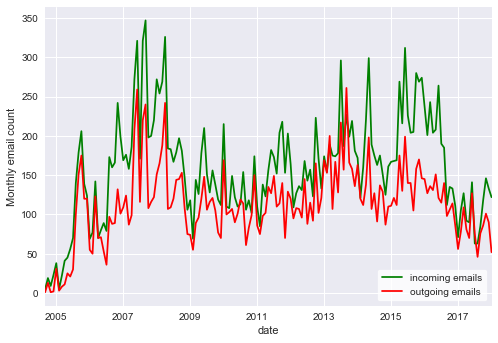

In [11]:
monthly_in = data_in['count'].resample('M').sum()
monthly_out= data_out['count'].resample('M').sum()
monthly_in.plot(color='g', label='incoming emails')
monthly_out.plot(color='r', label='outgoing emails')
plt.ylabel('Monthly email count')
plt.legend(loc='lower right', frameon=True).get_frame().set_color('white');

It can be seen that most of the time the number of received emails is greater than the number of emails sent. This trend appears only to be reversed in late 2013

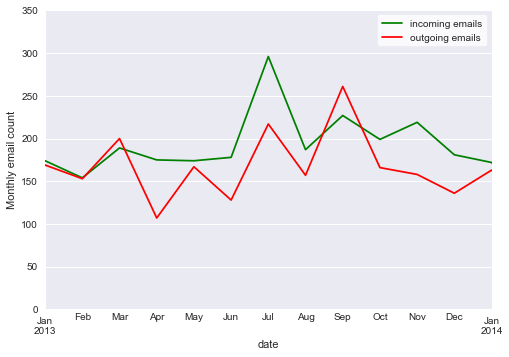

In [11]:
monthly_in.plot(color='g', label='incoming emails')
monthly_out.plot(color='r', label='outgoing emails')
plt.ylabel('Monthly email count')
plt.axis(['2013-01-27', '2014-01-27', 0, 350])
plt.legend(loc='best', frameon=True).get_frame().set_color('white');

More precisely during the month of Sep 2013 I sent significantly more emails than I received. Interestingly, this coincides with the potsdoc application period for the next year. Hence, the spike shows the many emails that I wrote regarding postdoc applications for 2014.

### 2. Busy days

We can now try to identify email activity vs. day of the week. We use the `timestamp` method `weekday()`, which returns an index $\in [0,\cdots, 6]$ corresponding to the days of the from Monday to Sunday.

In [12]:
dow = []
for i in range(len(df)):
    dow.append(df['date'][i].weekday())

Create new `series` with the day of the week of the message

In [13]:
df['dow'] = dow
df[['subject', 'date', 'dow', 'label']].head(4)

,subject,date,dow,label
0,Your Google data archive is ready,2018-01-27 18:30:32,5,"Important,Inbox"
1,None,2018-01-27 17:48:17,5,"Important,Jan"
2,None,2018-01-26 18:59:24,4,"Important,Jan"
3,"aantonop: ""Bitcoin Q&A: Layered scaling and pr...",2018-01-26 17:47:20,4,Trash


In [14]:
df_in = df[df['to'] == 'me']
df_out = df[df['from'] == 'me']

We can now get the distribution of messages per day of the week. For this a dictionary can easily capture the frequency of messages on each day

In [15]:
dow_in, dow_out = {}, {}
for i in range(7):
    dow_in[i] = 0
    dow_out[i] = 0
for i in df_in['dow']:
    dow_in[i] += 1
for i in df_out['dow']:
    dow_out[i] += 1

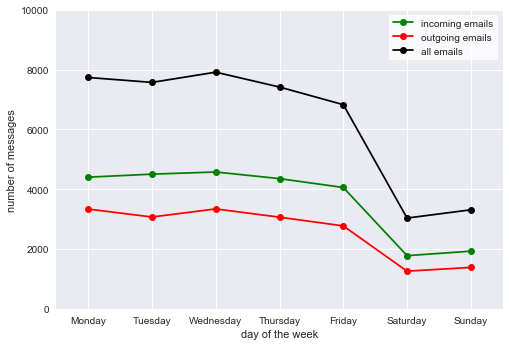

In [16]:
x, y_in, y_out, y_all = [], [], [], []
for key in dow_in.keys():
    x.append(key)
    y_in.append(dow_in[key])
    y_out.append(dow_out[key])
    y_all.append(dow_in[key] + dow_out[key])

plt.plot(x, y_in, 'o-', color='g', label='incoming emails')
plt.plot(x, y_out, 'o-', color='r', label='outgoing emails')
plt.plot(x, y_all, 'o-', color='k', label='all emails')
plt.axis([-0.5, 6.5, 0, 10000])
plt.xlabel('day of the week')
plt.ylabel('number of messages')
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xticks(x, days)
plt.legend(frameon=True).get_frame().set_color('white');

This plot shows clearly that the activity is quite uniform during the week days and it decreases during the weekens, as sort of expected.

### 3. Frequent contacts
Another immediate question that can be answered with this data is regarding the most frequent contacts I have received messages from and those to whom I have written the most. Just as done earlier with my email address that was replaced by the string `me`, the privacy of my contacts (I prefer not to post their email address) can be protected by creating a function that can replace their contact information with a nickname. Moreover, some of my contacts might have used different email addresses. For example, if I received emails from Richard Feynman (no, I didn't), his contact information can appear in a variety of forms:
- richard.feynman@qedmail.com
- "Feynman, Richard Phillips" richard.feynman@qedmail.com
- "Richard Feynman" richard.feynman@qedmail.com
- feynman_rules@qedmail.com

Even though they look different, they refer to the same contact. They  should all be replaced by a unique `nickname`. This can be achieved with the following helper function:

In [17]:
def nickname(txt, list_to_rename, new_name):
    txt = str(txt)
    for name in list_to_rename:
        if name in txt.lower():
            txt_out = new_name
            break
        else:
            txt_out = txt
    return txt_out

where `txt` is the text where the names on the list `list_to_rename` are been searched, if found they will be replaced by the nickname `new_name`. In the example above, the nickname for Feynman would be obtained in the form:
`df['from'] = df['from'].apply(lambda x: nickname(x, ['Feynman'], 'Richard F.'))`
As an explicit example, emails from amazon.com and amazon.de can be grouped together by using

In [18]:
amazon = ['amazon.de', 'amazon.com']
df['from'] = df['from'].apply(lambda x: nickname(x, amazon, 'Amazon'))

This is done for a few frequent contacts. The explicit lists are omitted for privacy. I have also included a list of my collaborators so they can all be represented by a unique nickname.

In [19]:
df['to'] = df['to'].apply(lambda x: nickname(x, jsd, 'me'))
df['to'] = df['to'].apply(lambda x: nickname(x, mjc, 'Maria J.'))
df['to'] = df['to'].apply(lambda x: nickname(x, vak, 'Alan K.'))
df['to'] = df['to'].apply(lambda x: nickname(x, coll, 'collaborators'))
df['to'] = df['to'].apply(lambda x: nickname(x, juan, 'Juan M.'))
df['to'] = df['to'].apply(lambda x: nickname(x, crm, 'Cristian M.'))
df['to'] = df['to'].apply(lambda x: nickname(x, rob, 'Roberto L.'))

The most frequent contacts that I have written to are

In [20]:
df['to'].value_counts()[1:7]

Maria J.         5334
Alan K.          1688
collaborators    1130
Juan M.           579
Cristian M.       512
nan               507
Name: to, dtype: int64

This shows `nan`

In [21]:
df = df[df['to'] != 'nan']
df = df.reset_index(drop=True)

In [22]:
df['to'].value_counts()[1:7]

Maria J.         5334
Alan K.          1688
collaborators    1130
Juan M.           579
Cristian M.       512
Roberto L.        422
Name: to, dtype: int64

This shows that after my PhD advisor (Alan K.), I have mostly written to my collaborators.
Similarly, for received messages we have

In [23]:
df['from'] = df['from'].apply(lambda x: nickname(x, jsd, 'me'))
df['from'] = df['from'].apply(lambda x: nickname(x, mjc, 'Maria J.'))
df['from'] = df['from'].apply(lambda x: nickname(x, vak, 'Alan K.'))
df['from'] = df['from'].apply(lambda x: nickname(x, coll, 'collaborators'))
df['from'] = df['from'].apply(lambda x: nickname(x, juan, 'Juan M.'))
df['from'] = df['from'].apply(lambda x: nickname(x, crm, 'Cristian M.'))
df['from'] = df['from'].apply(lambda x: nickname(x, rob, 'Roberto L.'))

where the most frequent contacts that have written to me are

In [24]:
df['from'].value_counts()[1:8]

Maria J.         5999
Alan K.          1733
collaborators    1360
Amazon           1202
Cristian M.       668
Juan M.           508
Roberto L.        461
Name: from, dtype: int64

This shows that after my PhD advisor (Alan K.), I have mostly received emails from my collaborators, followed closely from Amazon. All these results can be visualized

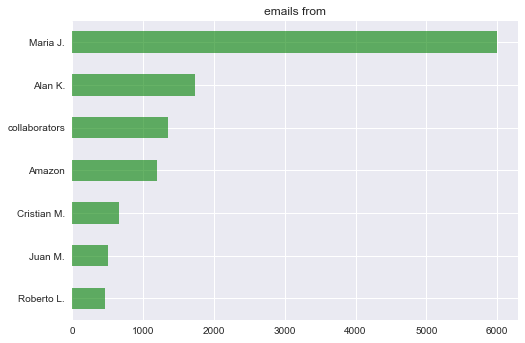

In [26]:
df['from'].value_counts()[1:8].plot(kind='barh', color='g', alpha=0.6).invert_yaxis()
plt.title('emails from');

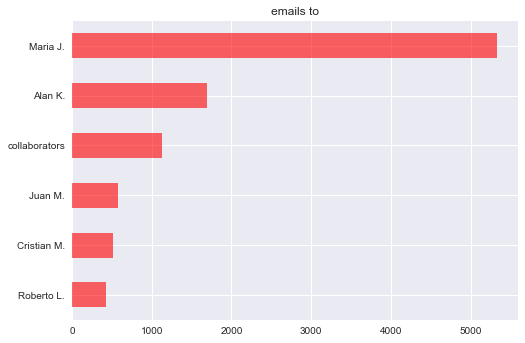

In [27]:
df['to'].value_counts()[1:7].plot(kind='barh', color='r', alpha=0.6).invert_yaxis()
plt.title('emails to');

### 4. Frequent contacts: deep dive
The exploration of the contacts that I most frequently interact with shows some clear appearance of my Ph.D. advisor and my research collaborators. In this section I would like to dive deeper into these two contacts to see if more interesting features show up.

#### 4.1 Messages with my Ph.D. advisor
Let us first consider the emails with my Ph.D. advisor. Once again, I use the dataframe defined earlier, with timestamps as the index of the dataframe. In these, the `nickname` transformation must be applied too. 

In [25]:
data['to'] = data['to'].apply(lambda x: nickname(x, vak, 'Alan K.'))
data['from'] = data['from'].apply(lambda x: nickname(x, vak, 'Alan K.'))

We can now define the incoming and outgoing messages

In [48]:
messages_in_ak = data[data['from'] == 'Alan K.']
messages_ou_ak = data[data['to'] == 'Alan K.']

By sampling in a monthly basis, the result can be directly visualized

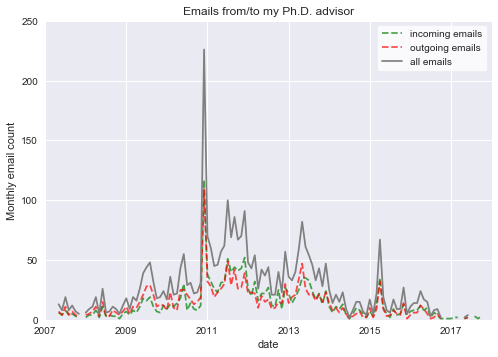

In [74]:
monthly_in_ak = messages_in_ak['count'].resample('M').sum()
monthly_out_ak = messages_ou_ak['count'].resample('M').sum()
monthly_all_ak = monthly_out_ak + monthly_in_ak
monthly_in_ak.plot(linestyle='--', color='g', alpha=0.7, label='incoming emails')
monthly_out_ak.plot(linestyle='--', color='r', alpha=0.7, label='outgoing emails')
monthly_all_ak.plot(linestyle='-', color='grey', label='all emails')
plt.ylabel('Monthly email count')
plt.title('Emails from/to my Ph.D. advisor')
plt.legend(loc='best', frameon=True).get_frame().set_color('white')
plt.axis(['2007-01-01', '2018-01-31', 0, 250]);

Some clear features (peaks) appear, in particular at the end of 2010 and I have a clear idea of what that is: that was a frantic Chrismas finishing our second paper, where we introduced the *puma model*. Many of the other peaks are also related to the release of papers. To make this clearer we can add here the messages with other collaborators:

In [137]:
data['to'] = data['to'].apply(lambda x: nickname(x, coll, 'collaborators'))
data['from'] = data['from'].apply(lambda x: nickname(x, coll, 'collaborators'))
messages_in_coll = data[(data['from'] == 'collaborators') & (data['to'] == 'me')]
messages_out_coll = data[(data['from'] == 'me') & (data['to'] == 'collaborators')]

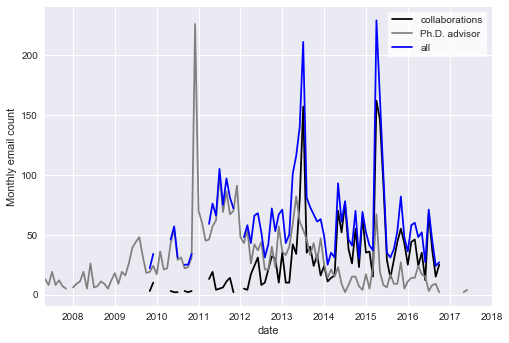

In [141]:
monthly_in_coll = messages_in_coll['count'].resample('M').sum()
monthly_out_coll = messages_ou_coll['count'].resample('M').sum()
monthly_all_coll = monthly_out_coll + monthly_in_coll
monthly_all = monthly_all_ak + monthly_all_coll
monthly_all_coll.plot(linestyle='-', color='k', label='collaborations')
monthly_all_ak.plot(linestyle='-', color='grey', label='Ph.D. advisor')
monthly_all.plot(linestyle='-', color='blue', label='all')
plt.ylabel('Monthly email count')
plt.legend(loc='best', frameon=True).get_frame().set_color('white')
# plt.annotate('   1st\n paper', xy=('2009-08-10', 50), 
#              xytext=('2008-08-10', 100),
#              arrowprops=dict(facecolor='black', shrink=0.05))
# plt.annotate('   2nd\n paper', xy=('2010-12-29', 150), 
#              xytext=('2009-08-10', 200),
#              arrowprops=dict(facecolor='black', shrink=0.05))
# plt.annotate('   3rd\n paper', xy=('2011-08-08', 105), 
#              xytext=('2011-08-10', 155),
#              arrowprops=dict(facecolor='black', shrink=0.05))
# plt.annotate('   4th\n paper', xy=('2013-05-20', 90), 
#              xytext=('2012-12-01', 125),
#              arrowprops=dict(facecolor='black', shrink=0.05));

In [110]:
df[df['to'] == 'collaborators'].tail()

,subject,from,to,date,label,count,dow
39778,Re: Teppei's talk about tandem model at pheno 08,me,collaborators,2008-04-21 04:34:34,"AK,Sent,old_stuff/IU_mail",1,0
39800,Re: Teppei's talk about tandem model at pheno 08,Alan K.,collaborators,2008-04-18 23:40:32,"AK,old_stuff/IU_mail",1,4
39839,Re: Teppei's talk about tandem model at pheno 08,Alan K.,collaborators,2008-04-17 11:33:58,"AK,old_stuff/IU_mail",1,3
43473,Re: Tandem Model,me,collaborators,2007-08-29 19:13:16,Sent,1,2
43481,Tandem Model,me,collaborators,2007-08-29 15:57:36,"old_stuff/_Research,Sent",1,2


In [136]:
messages_out_coll.tail(100)#loc['2009-11-29':'2010-12-29']
#data[(data['from'] == 'collaborators') & (data['to'] == 'me')]#.tail(100)
# data[(data['from'] == 'collaborators') & (data['to'] == 'me')]

,subject,from,to,label,count
date,,,,,
2012-10-01 00:51:42,Re: NNN workshop,me,collaborators,"Sent,old_stuff/IU_mail",1
2012-09-29 14:43:13,Re: code for calculating g & H survival probab...,me,collaborators,"old_stuff/_Research/Contacts,Sent,old_stuff/IU...",1
2012-09-28 23:03:24,Re: code for calculating g & H survival probab...,me,collaborators,"old_stuff/_Research/Contacts,Sent,old_stuff/IU...",1
2012-09-28 17:57:37,Re: code for calculating g & H survival probab...,me,collaborators,"old_stuff/_Research/Contacts,Sent,old_stuff/IU...",1
2012-09-28 17:20:00,Re: code for calculating g & H survival probab...,me,collaborators,"old_stuff/_Research/Contacts,Sent,old_stuff/IU...",1
2012-09-27 23:09:12,NNN workshop,me,collaborators,"old_stuff/_Research/Contacts,Sent,old_stuff/IU...",1
2012-09-27 23:06:01,Re: code for calculating g & H survival probab...,me,collaborators,"old_stuff/_Research/Contacts,Sent,old_stuff/IU...",1
2012-09-24 17:44:07,Re: neutrino theory postdoc,me,collaborators,"Sent,old_stuff/IU_mail",1
2012-09-19 17:48:18,Re: neutrino theory postdoc,me,collaborators,"Sent,old_stuff/IU_mail",1


In [29]:
name = 'Alan K.' #'collaborators' #
mess_from = df[['date']][df['from'] == name]
mess_to = df[['date']][df['to'] == name]

In [30]:
mess_from.set_index('date', drop=False, inplace=True)
mess_to.set_index('date', drop=False, inplace=True)

In [31]:
counts_to = [1 for _ in range(len(mess_to))]
counts_from = [1 for _ in range(len(mess_from))]
mess_to['counts'] = counts_to
mess_from['counts'] = counts_from

In [32]:
del mess_from['date']
del mess_to['date']

C:\Users\jsdiaz\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.
C:\Users\jsdiaz\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  


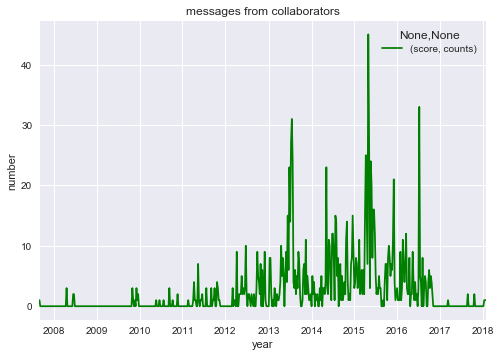

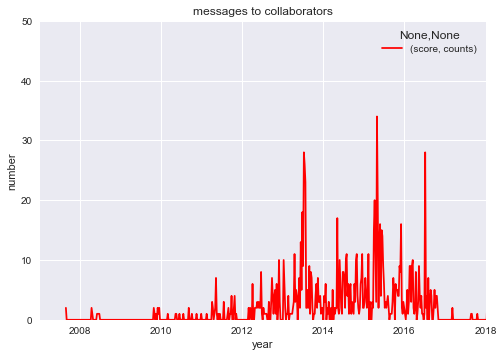

In [36]:
b = mess_from.resample('W').apply({'score':'count'})
c = mess_to.resample('W').apply({'score':'count'})
b.plot(color='g')
plt.title('messages from {}'.format(name))
plt.ylabel('number')
plt.xlabel('year');

c.plot(color='r')
plt.title('messages to {}'.format(name))
plt.ylabel('number')
plt.xlabel('year')
plt.axis(['2007-01-01', '2018-01-01', 0, 50]);

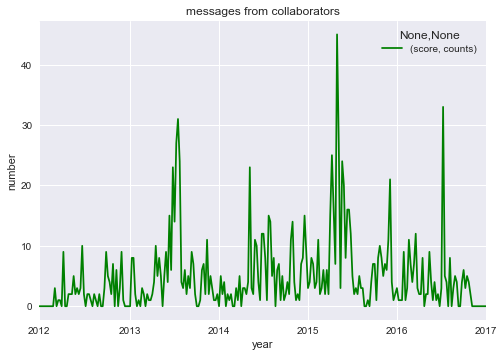

In [37]:
b['2012-01-01':'2017-01-01'].plot(color='g')
plt.title('messages from {}'.format(name))
plt.ylabel('number')
plt.xlabel('year');

### 5. Most common topics
The content of the messages is unavailable; however, the subject of each message can clearly indicate the recurrent topics for both incoming and outgoing emails.

In [60]:
all_wrds_in = []
for wrds in list(df['subject'][df['to'] == 'me']):
    all_wrds_in.extend(str(wrds).lower().split())
    
all_wrds_out = []
for wrds in list(df['subject'][df['from'] == 'me']):
    all_wrds_out.extend(str(wrds).lower().split())

In [62]:
all_wrds_in[:6]

['your', 'google', 'data', 'archive', 'is', 'ready']

In [97]:
my_stopwords = ['re:', 'nan', 'none', '-', 'fwd:', 'fw:', 
                '&', 'hola', 'saludos', 'order', 'amazon.com']

In [98]:
from nltk.corpus import stopwords
stopwords_en = set(stopwords.words('english'))
stopwords_es = set(stopwords.words('spanish'))
all_stopwords = stopwords_en | stopwords_es | set(my_stopwords)

In [99]:
len(all_wrds_in), len(all_wrds_out)

(58020, 29497)

In [100]:
all_wrds_in = [wrd for wrd in all_wrds_in if wrd not in all_stopwords]
all_wrds_out = [wrd for wrd in all_wrds_out if wrd not in all_stopwords]

In [101]:
len(all_wrds_in), len(all_wrds_out)

(57978, 29444)

In [102]:
wrds_in = Counter(all_wrds_in)
wrds_out = Counter(all_wrds_out)

In [103]:
wrds_in.most_common(20)

[('question', 296),
 ('paper', 276),
 ('new', 272),
 ('physics', 263),
 ('lorentz', 242),
 ('consulta', 241),
 ('meeting', 218),
 ('library', 199),
 ('update', 172),
 ('application', 167),
 ('reminder', 167),
 ('report', 165),
 ('ready', 162),
 ('amazon.de', 161),
 ('jorge', 160),
 ('diaz', 160),
 ('confirmation', 157),
 ('violation', 155),
 ('pregunta', 151),
 ('aw:', 148)]

In [104]:
wrds_out.most_common(20)

[('question', 389),
 ('paper', 278),
 ('lorentz', 261),
 ('consulta', 253),
 ('report', 182),
 ('violation', 162),
 ('seminar', 144),
 ('update', 142),
 ('talk', 141),
 ('pregunta', 137),
 ('application', 134),
 ('letter', 129),
 ('new', 124),
 ('visit', 123),
 ('postdoc', 121),
 ('meeting', 120),
 ('lv', 115),
 ('recommendation', 107),
 ('invariance', 100),
 ('cpt', 99)]

In [105]:
from wordcloud import WordCloud, STOPWORDS

In [106]:
words_in = ''
for t in wrds_in.most_common(150):
    for i in range(t[1]):
        words_in += t[0] + ' '
        
words_out = ''
for t in wrds_out.most_common(150):
    for i in range(t[1]):
        words_out += t[0] + ' '

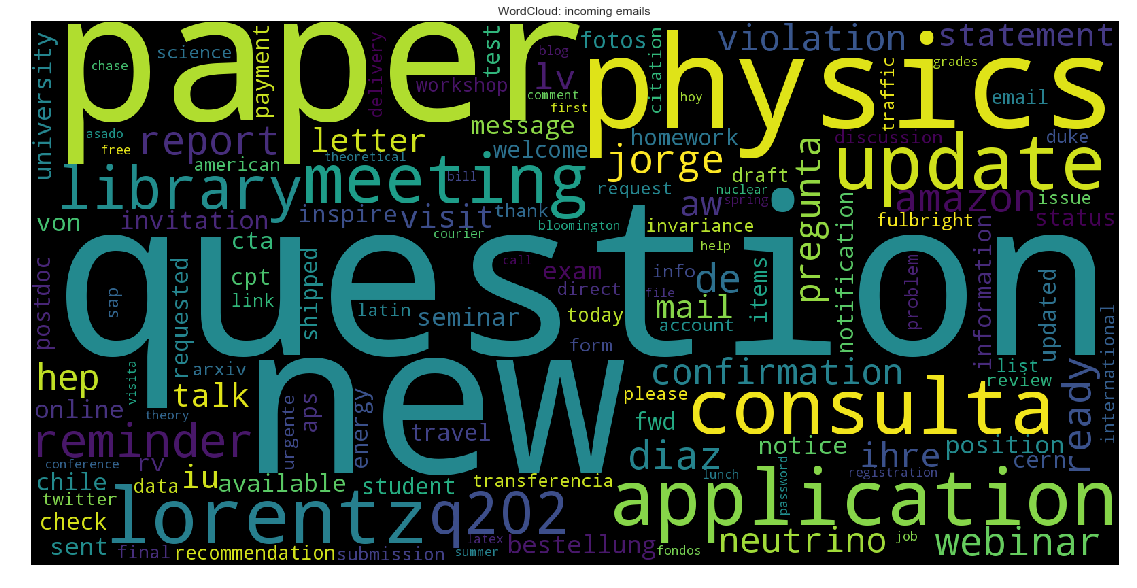

In [107]:
wordcloud_in = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=1600, height=800,
                      collocations=False
                     ).generate(words_in)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud_in)
plt.axis('off')
plt.title('WordCloud: incoming emails');

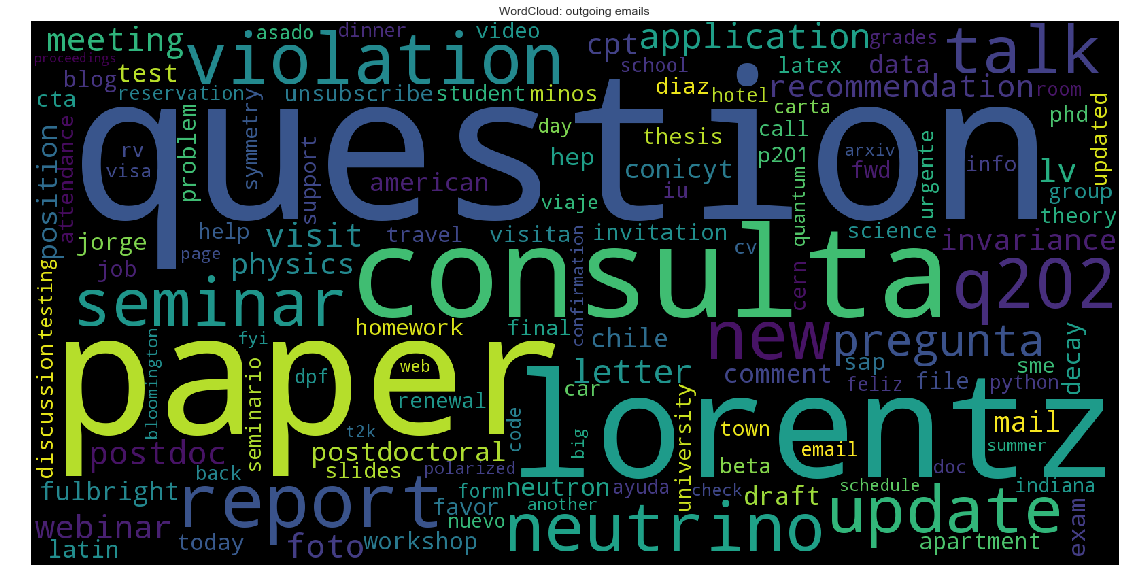

In [108]:
wordcloud_out = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=1600, height=800,
                      collocations=False
                     ).generate(words_out)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud_out)
plt.axis('off')
plt.title('WordCloud: outgoing emails');+